In [2]:
import numpy as np
import torch
import torch.distributions.constraints as constraints
import torch.distributions as tdist
import pyro
import pyro.infer
import pyro.optim
import pyro.distributions as dist
from pyro.infer.autoguide import AutoNormal
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle as pkl

pyro.set_rng_seed(101)
pyro.__version__


'1.8.4+9ed468d'

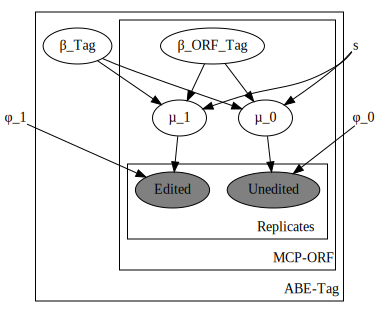

In [7]:
# mu and sigma params
# sample beta_j from normal(mu, sigma)

def model_NB_mixture():
    n_tags = 20
    n_orfs = 4000
    n_reps = 3

    size_factors = pyro.param("s", init_tensor = torch.ones(n_tags,))
    dispersion_0 = pyro.param("φ_0", init_tensor = .01 * torch.ones(n_tags,))
    dispersion_1 = pyro.param("φ_1", init_tensor = .01 * torch.ones(n_tags,))

    with pyro.plate("ABE-Tag", n_tags):
        beta_tag = pyro.sample("β_Tag", dist.Normal(0,1))
        with pyro.plate("MCP-ORF", n_orfs):
            beta_orf_tag = pyro.sample("β_ORF_Tag", dist.Normal(0,1))
            # pi = pyro.param("π", init_tensor = torch.tensor(1))
            # q = pyro.param("q", init_tensor = torch.tensor(1))
            mu_0 = pyro.sample("µ_0", dist.Uniform(0,size_factors*beta_tag*beta_orf_tag))
            mu_1 = pyro.sample("µ_1", dist.Uniform(0,size_factors*beta_tag*beta_orf_tag))
            with pyro.plate("Replicates", n_reps):
                pyro.sample(
                    "Edited",
                    dist.Uniform(mu_1,dispersion_1), obs = 1
                )
                pyro.sample(
                    "Unedited", dist.Uniform(mu_0,dispersion_0),obs = 1
                )

pyro.render_model(
    model_NB_mixture, render_params=True
)